# DATA LOADING AND EXPLORATION



 Libraries imported successfully
Dataset loaded
Shape: (150000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        

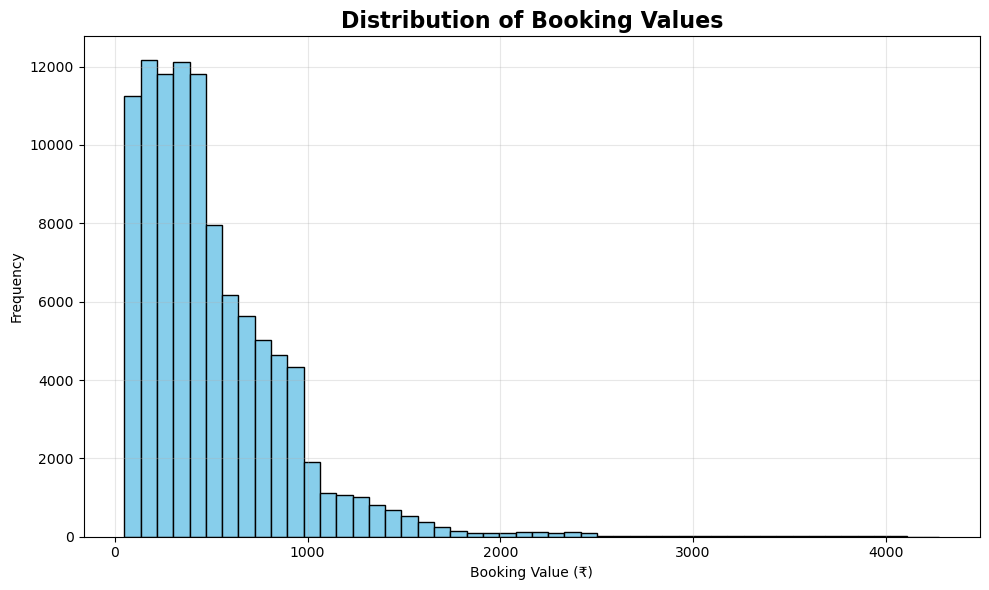

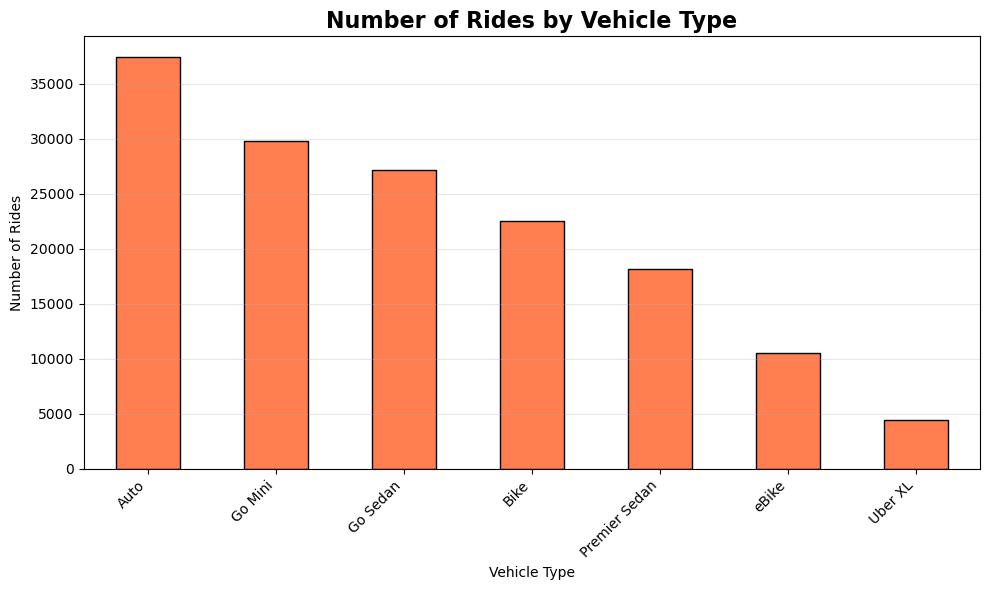

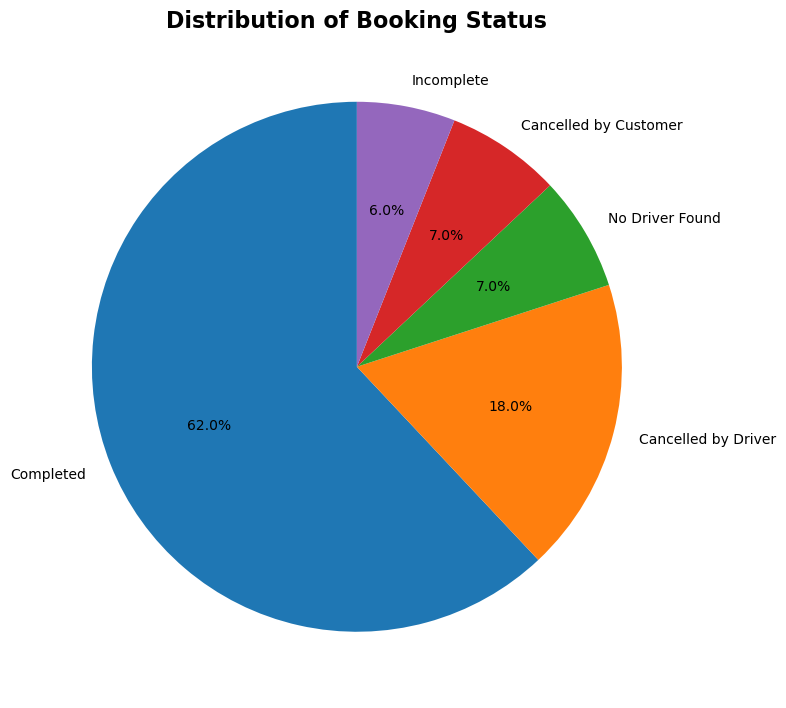

In [8]:
#==================================================================
#SESSION 1: DATA LOADING AND EXPLORATION
#==================================================================

#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

print("\n Libraries imported successfully")

# Load data
df= pd.read_csv('ncr_ride_bookings.csv')
print("Dataset loaded")
print(f"Shape: {df.shape}")

# First look
df.head()
df.tail()
df.info()
df.describe()
df.columns.tolist()
df.dtypes

# Data quality checks
#Missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
print(missing_percent[missing_percent > 0])

#Duplicates
duplicate_count = df.duplicated().sum()
print(f" Number of duplicated rows: {duplicate_count}")
if duplicate_count > 0:
    duplicates =df[df.duplicated()]
    print(duplicates.head())

#unique values in categorical columns
df['Booking Status'].value_counts()
df['Vehicle Type'].value_counts()
df['Payment Method'].value_counts()
df['Pickup Location'].value_counts().head(10)

# BASIC QUESTIONS
# Total bookings
total_bookings = len(df)
print(f" Total bookings: {total_bookings:,}")

#Total revenue
total_revenue = df['Booking Value'].sum()
avg_booking = df['Booking Value'].mean()
median_booking = df['Booking Value'].median()
print(f"Total Revenue: {total_revenue:,.2f}")
print(f"Average booking: {avg_booking:.2f}")
print(f"Median booking: {median_booking:.2f}")

# Unique customers
unique_customers = df['Customer ID'].nunique()
avg_bookings_per_customer = len(df) / unique_customers
print(f" Unique customers: {unique_customers:,}")
print(f" Average bookings per customer: {avg_bookings_per_customer:.2f}")

#Completion rate
status_count = df['Booking Status'].value_counts()
print("\n Bookind Status distribution")
print(status_count)

total_rides = len(df)
completed_rides = status_count['Completed']
completion_rate = (completed_rides/total_rides)* 100

print(f" Completion rate: {completion_rate:.1f}%") # industry standard should be > 85%
print(f" Cancellation rate: {100 - completion_rate:.2f}%")

# 6. SIMPLE VISUALIZATIONS
# Histogram - Booking Value
plt.figure(figsize=(10, 6))
plt.hist(df['Booking Value'].dropna(), bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Booking Values', fontsize=16, fontweight='bold')
plt.xlabel('Booking Value (₹)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Bar chart - Vehicle Type
plt.figure(figsize=(10, 6))
df['Vehicle Type'].value_counts().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Number of Rides by Vehicle Type', fontsize=16, fontweight='bold')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Pie chart - Booking Status
plt.figure(figsize=(8, 8))
df['Booking Status'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Booking Status', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

## DATA CLEANING


In [16]:
#=========================================================================
# DATA CLEANING
#=========================================================================

# CREATE COPY
df_clean = df.copy()
print(f" Original shape: {df.shape}")

# HANDLE MISSING VALUES - CANCELLATION COLUMNS
cancellation_cols = [
    'Cancelled Rides by Customer',
    'Cancelled Rides by Driver',
    'Incomplete Rides'
]

for col in cancellation_cols:
    df_clean[col] = df_clean[col].fillna(0)
    print(f" Filled {col}")

#Reason columns
reason_cols = [
    'Reason for cancelling by Customer',
    'Driver Cancellation Reason',
    'Incomplete Rides Reason'
]

for col in reason_cols:
    df_clean[col] = df_clean[col].fillna('Not Applicable')
    print(f" Filled {col}")

# Ratings - fill with median
df_clean['Driver Ratings'] = df_clean['Driver Ratings'].fillna(df_clean['Driver Ratings'].median())
df_clean['Customer Rating'] = df_clean['Customer Rating'].fillna(df_clean['Customer Rating'].median())
print("Ratings filled")

#Verify 
print(f" Missing values remaining: {df_clean.isnull().sum().sum()}")

# DATA TYPE CONVERSIONS
# Date
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
print(f" Date type: {df_clean['Date'].dtype}")

#Time
df_clean['Time'] = pd.to_datetime(df_clean['Time'] , format = '%H:%M:%S').dt.time

#EXTRACT DATE COMPONENTS
df_clean['Day_of_Week'] = df_clean['Date'].dt.day_name()
df_clean['Month'] = df_clean['Date'].dt.month_name()
df_clean['Day'] = df_clean['Date'].dt.day
df_clean['Hour'] = pd.to_datetime(df_clean['Time'].astype(str), format = '%H:%M:%S').dt.hour
df_clean['Is_Weekend'] = df_clean['Date'].dt.dayofweek >= 5

print("Date components extracted")
print(df_clean[['Date', 'Day_of_Week', 'Month', 'Hour', 'Is_Weekend']].head())

# CREATE RIDE OUTCOME COLUMN
df_clean['Ride_Outcome'] = 'Completed'
df_clean.loc[df_clean['Cancelled Rides by Customer'] > 0, 'Ride_Outcome'] = 'Cancelled by Customer'
df_clean.loc[df_clean['Cancelled Rides by Driver'] > 0, 'Ride_Outcome'] = 'Cancelled by Driver'
df_clean.loc[df_clean['Incomplete Rides'] > 0, 'Ride_Outcome'] = 'Incomplete'

print("Ride outcome distribution")
print(df_clean['Ride_Outcome'].value_counts())

# CLEAN TEXT COLUMNS
df_clean['Vehicle Type'] = df_clean['Vehicle Type'].str.strip() #Remove leading or trailing spaces
df_clean['Pickup Location'] = df_clean['Pickup Location'].str.strip()
df_clean['Drop Location'] = df_clean['Drop Location'].str.strip()
df_clean['Payment Method'] = df_clean['Payment Method'].str.strip()


print("Text Columns cleaned")

#OUTLIER DETECTION
#Values beyond 3 standard deviations
# Booking value outliers
bv_mean = df_clean['Booking Value'].mean()
bv_std = df_clean['Booking Value'].std()
bv_lower = bv_mean - 3*bv_std
bv_upper = bv_mean + 3*bv_std
bv_outliers = df_clean[(df_clean['Booking Value'] < bv_lower) | (df_clean['Booking Value'] > bv_upper)]
print(f"Booking value outliers: {len(bv_outliers)} ({len(bv_outliers)/ len(df_clean) * 100:.2f}%)")

#Homework: do outlier detection for ride distance
#Flag outliers
df_clean['Is_High_Value'] = df_clean['Booking Value'] > df_clean['Booking Value'].quantile(0.95)
df_clean['Is_Long_Distance'] = df_clean['Ride Distance'] > df_clean['Ride Distance'].quantile(0.95)

# SAVE CLEANED DATA
df_clean.to_csv('ncr_ride_bookings_cleaned.csv', index = False)
print("Cleaned data saved")

 Original shape: (150000, 21)
 Filled Cancelled Rides by Customer
 Filled Cancelled Rides by Driver
 Filled Incomplete Rides
 Filled Reason for cancelling by Customer
 Filled Driver Cancellation Reason
 Filled Incomplete Rides Reason
Ratings filled
 Missing values remaining: 202500
 Date type: datetime64[ns]
Date components extracted
        Date Day_of_Week      Month  Hour  Is_Weekend
0 2024-03-23    Saturday      March    12        True
1 2024-11-29      Friday   November    18       False
2 2024-08-23      Friday     August     8       False
3 2024-10-21      Monday    October    17       False
4 2024-09-16      Monday  September    22       False
Ride outcome distribution
Ride_Outcome
Completed                103500
Cancelled by Driver       27000
Cancelled by Customer     10500
Incomplete                 9000
Name: count, dtype: int64
Text Columns cleaned
Booking value outliers: 1444 (0.96%)
Cleaned data saved
